## Final Project 

## Credit Default Swap Replication Exercise

This Jupyter Notebook provides a comprehensive and structured walkthrough of the process of replicating Credit Default Swap (CDS) returns. The notebook is designed to guide the reader through each step, from data extraction to final analysis, ensuring a clear understanding of the methodology used to reconstruct and validate CDS return series. The process is explained as follows: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from pathlib import Path
from settings import config
from pull_markit import load_markit_data, load_multiple_data, load_sector_data
from pull_rf_data import load_fed_yield_curve, load_fred_data

In [2]:
# Configure Data Directories
DATA_DIR = Path(config("DATA_DIR"))
MANUAL_DATA_DIR = Path(config("MANUAL_DATA_DIR"))

In [3]:
# Display settings for Pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)

## Data Extraction and Preprocessing

In [4]:
from settings import config
from pull_markit import load_markit_data, load_multiple_data, load_sector_data
from pull_cds_return_data import pull_real_cds_return, unpivot_table
from calc_cds_daily_return import calc_cds_daily_return

In [11]:
# Step 1: Load Markit Data - Merge all Available Yearly CDS Files
markit_files = list(DATA_DIR.glob("markit_cds*.parquet"))  # Find all relevant files

if not markit_files:
    raise FileNotFoundError("No Markit CDS files found in the directory!")

markit_list = [pd.read_parquet(file) for file in markit_files]  # Load all files
markit = pd.concat(markit_list, ignore_index=True)  # Merge into a single DataFrame

In [33]:
# Print first 5 rows
print(markit.head())

  ticker trade_date  spread      sector  year  lambda
0      A 2022-01-03   0.010  Healthcare  2002   0.017
1      A 2022-01-04   0.010  Healthcare  2002   0.017
2      A 2022-01-05   0.010  Healthcare  2002   0.017
3      A 2022-01-06   0.010  Healthcare  2002   0.017
4      A 2022-01-07   0.010  Healthcare  2002   0.017


In [12]:
# Step 2: Load Additional Data
sector_df = load_sector_data()  # Load sector information
real_cds_return = pull_real_cds_return()  # Load real CDS return data


In [13]:
# Step 3: Filter out financial and government sectors
def filter_sector(markit, sector_df):
    """Filter out financial and government sectors from Markit data."""
    markit = pd.merge(markit, sector_df, on="ticker", how="left")
    markit = markit[~markit["sector"].isin(["Financials", "Government"])]
    return markit

markit = filter_sector(markit, sector_df)

In [14]:
# Step 4: Compute CDS Default Intensity (Lambda)
def calc_lambda(cds_df, L=0.6):
    """Calculate default intensity (lambda) using CDS spreads."""
    cds_df["lambda"] = 12 * np.log(1 + cds_df["spread"] / (12 * L))
    return cds_df

In [ ]:
# Step 5: Compute Risky Duration (RD)
def calc_RD(cds_df, maturity=5):
    """Compute risk-neutral default probability RD."""
    
    # Ensure a copy is used to prevent SettingWithCopyWarning
    cds_df = cds_df.copy()
    
    # Check if necessary columns exist
    if cds_df.empty:
        raise ValueError("Error: Markit DataFrame is empty! Ensure Markit data is properly loaded.")
    
    required_cols = ["spread", "trade_date"]
    for col in required_cols:
        if col not in cds_df.columns:
            raise ValueError(f"Error: '{col}' column is missing from the data!")
    
    cds_df["trade_date"] = pd.to_datetime(cds_df["trade_date"])

    # Compute lambda first
    cds_df["lambda"] = 12 * np.log(1 + cds_df["spread"] / (12 * 0.6))  # Assuming L=0.6

    # Initialize RD column
    cds_df["RD"] = 0.0  

    # Compute Risky Duration (RD)
    for j in range(1, 12 * maturity + 1):  
        cds_df["RD"] += np.exp(-j / 12 * cds_df["lambda"])
    
    cds_df["RD"] /= 12  # Normalize

    # Sort by ticker and date for consistency
    cds_df = cds_df.sort_values(["ticker", "trade_date"])
    
    # Create lagged columns
    cds_df["RD_prev"] = cds_df.groupby("ticker")["RD"].shift(1)
    cds_df["spread_prev"] = cds_df.groupby("ticker")["spread"].shift(1)
    
    return cds_df.dropna(subset=["RD_prev", "spread_prev"])  # Drop NaNs due to shifting


In [19]:
# Step 6: Compute Final CDS Daily Returns
final_df = calc_cds_daily_return(rd_df)

In [20]:
# Step 7: Save Processed Data
data_path = DATA_DIR / "CDS_daily_return.parquet"
final_df.to_parquet(data_path)

In [ ]:
# Step 8: Data Summary and Visualizations
print("Final Processed Data:")
display(final_df.head())

Final Processed Data:


,ticker,trade_date,spread,sector,year,lambda,RD,RD_prev,spread_prev,daily_return
3344105,A,2002-02-05,0.047,Healthcare,2002,0.078,4.129,4.086,0.050,0.011
3345751,A,2002-02-06,0.047,Healthcare,2002,0.078,4.129,4.129,0.047,-0.000
3350326,A,2002-02-07,0.047,Healthcare,2002,0.078,4.129,4.129,0.047,-0.000
3264874,A,2002-02-08,0.047,Healthcare,2002,0.078,4.129,4.129,0.047,-0.000
3313050,A,2002-02-11,0.047,Healthcare,2002,0.078,4.129,4.129,0.047,-0.000


In [22]:

print("\nSummary Statistics:")
display(final_df.describe())


Summary Statistics:


,trade_date,spread,year,lambda,RD,RD_prev,spread_prev,daily_return
count,3986945,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000
mean,2013-02-15 17:10:49.254103552,0.024,2004.560,0.039,4.621,4.621,0.024,-0.000
min,2001-01-03 00:00:00,0.000,2001.000,0.000,0.002,0.045,0.000,-34.405
25%,2007-11-26 00:00:00,0.005,2001.000,0.008,4.537,4.537,0.005,-0.000
50%,2012-08-30 00:00:00,0.010,2003.000,0.016,4.803,4.803,0.010,-0.000
75%,2018-05-11 00:00:00,0.023,2006.000,0.039,4.897,4.897,0.023,0.000
max,2025-03-14 00:00:00,345.600,2025.000,46.702,4.999,4.999,13.466,0.589
std,NaN,0.191,4.726,0.121,0.501,0.501,0.080,0.021


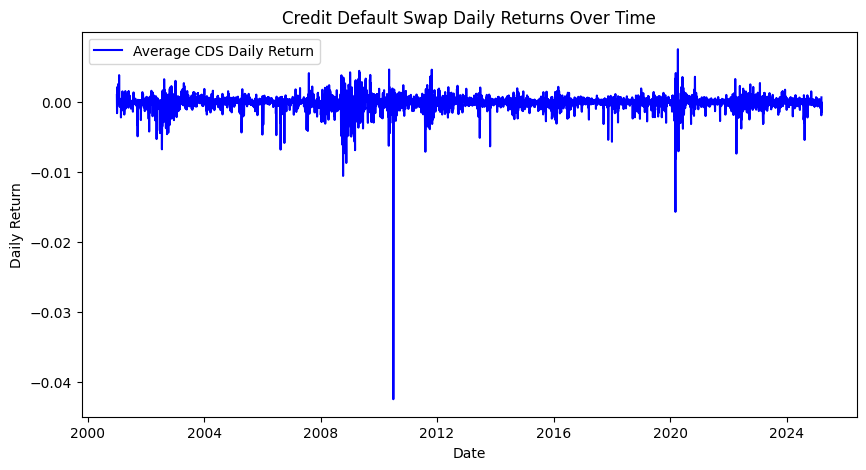

In [24]:
# Time-Series Plot of CDS Returns
plt.figure(figsize=(10, 5))
plt.plot(final_df.groupby("trade_date")["daily_return"].mean(), label="Average CDS Daily Return", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Credit Default Swap Daily Returns Over Time")
plt.legend()
plt.show()

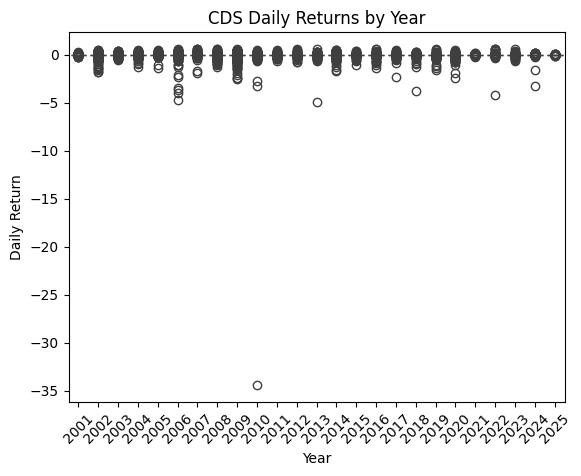

In [30]:
import seaborn as sns  
import matplotlib.pyplot as plt

# Boxplot of Returns Over Years
sns.boxplot(x=final_df["trade_date"].dt.year, y=final_df["daily_return"])
plt.xlabel("Year")
plt.ylabel("Daily Return")
plt.title("CDS Daily Returns by Year")
plt.xticks(rotation=45)
plt.show()



In [27]:
# Correlation Matrix
correlation_matrix = final_df[["spread", "RD", "daily_return"]].corr()
print("\nCorrelation Matrix:")
display(correlation_matrix)


Correlation Matrix:


,spread,RD,daily_return
spread,1.000,-0.297,-0.786
RD,-0.297,1.000,0.046
daily_return,-0.786,0.046,1.000
